# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [1]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

### I next want to get a list of all of my functional files

In [2]:
sid = ['021']
base_dir = '/home/nmatt015/Mattfeld_PSB6351/'
work_dir = '/scratch/madlab/Mattfeld_PSB6351/nmatt015/'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/func')
fmap_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/fmap')
fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')
os.environ['SUBJECTS_DIR'] = fs_dir

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
func_files = sorted(glob(func_dir + '/*.nii.gz'))
fmap_files = sorted(glob(fmap_dir + '/*func*.nii.gz'))

In [4]:
func_files[0]

'/home/nmatt015/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-1_bold.nii.gz'

In [ ]:
# Tried running it on the Jupyter notebook because recon-all.py wouldn't work. Couldn't stay connected to Jupyter notebook
# long enough for this to finish. 
import os
import subprocess as sp
from pathlib import Path
from glob import glob

# Set FreeSurfer and TMPDIR environment paths
freesurfer_home = "/home/applications/freesurfer/7.1/freesurfer"
os.environ['PATH'] += f":{freesurfer_home}/bin/"
os.environ['FREESURFER_HOME'] = freesurfer_home
os.environ['TMPDIR'] = '/scratch/madlab/Mattfeld_PSB6351/nmatt015'  # Set TMPDIR

# Specify subject ID
subject = "021"  # Example subject ID

# Define the input image path
anat_img = sorted(glob(
    f"/home/nmatt015/Mattfeld_PSB6351/dset/sub-{subject}/anat/sub-{subject}_run-?_T1w.nii.gz"
))[-1]

# Define the recon-all command
cmd = [
    "recon-all", "-all",
    "-i", anat_img,
    "-openmp", "4",
    "-subjid", f"sub-{subject}",
    "-sd", "/home/nmatt015/Mattfeld_PSB6351/derivatives/freesurfer/"
]

# Run the command
sp.run(cmd)

In [8]:
ls /home/nmatt015/Mattfeld_PSB6351/derivatives/freesurfer/sub-021/

label/  mri/  scripts/  stats/  surf/  tmp/  touch/  trash/


In [5]:
os.environ['PATH'] += ':/home/applications/fsl/6.0.6/bin'
!which fslmaths # needed this to get fslmaths to work

/home/applications/fsl/6.0.6/bin/fslmaths


### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [6]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

# HW3 - change the search window. how does this impact your results?
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information?
####################################
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
####################################
# HW3 - what happens if you chose a different func_file?  How does it impact results
# Is the first func file the best way to go?
####################################
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
####################################
# HW3 - if you choose a different func file...should this change too?
# If yes, why?  what should it change to?
####################################
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

####################################
# HW3 - what happens when you change the order of the following two nodes?
# How does that impact your results?
# Run things again with the order reversed and save in a new sink folder without deleting your first
####################################
volreg1st = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg1st')
volreg1st.inputs.outputtype = 'NIFTI_GZ'
volreg1st.inputs.zpad = 4
volreg1st.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg1st, 'basefile')

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter2nd = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter2nd')
tshifter2nd.inputs.tr = '1.76'
tshifter2nd.inputs.slice_timing = slice_timing_list
tshifter2nd.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(volreg1st, 'out_file', tshifter2nd, 'in_file')

# Coregister with FLIRT, I tried with BBregister but couldn't figure out issues with recon all
coregister = pe.MapNode(fsl.FLIRT(),
                        iterfield=['in_file'], 
                        name='coregister')
coregister.inputs.output_type = 'NIFTI_GZ'
coregister.inputs.dof = 6
coregister.inputs.reference = '/home/nmatt015/Mattfeld_PSB6351/dset/sub-021/anat/sub-021_run-1_T1w.nii.gz'
coregister.inputs.in_file = func_files
psb6351_wf.connect(volreg1st, 'out_file', coregister, 'in_file')

# HW5, add node for spatial smoothing 
# HW5, add node for 1mm spatial smoothing
spatial_smooth_1mm = pe.MapNode(fsl.ImageMaths(),
                 iterfield=['in_file'],
                 name='spatial_smooth_1mm')
spatial_smooth_1mm.inputs.op_string = '-s 1.0'  # Using a 1mm kernel
spatial_smooth_1mm.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect(coregister, 'out_file', spatial_smooth_1mm, 'in_file')

# HW5, add node for 10mm spatial smoothing to see what changes
spatial_smooth_10mm = pe.MapNode(fsl.ImageMaths(),
                  iterfield=['in_file'],
                  name='spatial_smooth_10mm')
spatial_smooth_10mm.inputs.op_string = '-s 10.0'  # Using a 10mm kernel
spatial_smooth_10mm.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect(coregister, 'out_file', spatial_smooth_10mm, 'in_file')

# HW5, add node for 100mm spatial smoothing just for fun 
spatial_smooth_100mm = pe.MapNode(fsl.ImageMaths(),
                  iterfield=['in_file'],
                  name='spatial_smooth_100mm')
spatial_smooth_100mm.inputs.op_string = '-s 100.0'  # Using a 100mm kernel
spatial_smooth_100mm.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect(coregister, 'out_file', spatial_smooth_100mm, 'in_file')

# HW5, add node for temporal smoothing 
temporal_smooth = pe.MapNode(fsl.ImageMaths(),
                          iterfield=['in_file'],
                          name='temporal_smooth')
temporal_smooth.inputs.op_string = '-bptf 28.41 -1'  # 100 / (2*1.76s) = 28.41 
temporal_smooth.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect(spatial_smooth_1mm, 'out_file', temporal_smooth, 'in_file')

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc')
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(tshifter2nd, 'out_file', datasink, 'sltime_corr2nd')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(volreg1st, 'out_file', datasink, 'motion1stAFNI.@corrfile')
psb6351_wf.connect(volreg1st, 'oned_matrix_save', datasink, 'motion1stAFNI.@matrix')
psb6351_wf.connect(volreg1st, 'oned_file', datasink, 'motion1stAFNI.@par')
psb6351_wf.connect(coregister, 'out_file', datasink, 'coregistration.@registered_func')
psb6351_wf.connect(coregister, 'out_matrix_file', datasink, 'coregistration.@transform_matrix')
psb6351_wf.connect(spatial_smooth_1mm, 'out_file', datasink, 'smoothing.@smoothed_1mm')
psb6351_wf.connect(spatial_smooth_10mm, 'out_file', datasink, 'smoothing.@smoothed_10mm')
psb6351_wf.connect(spatial_smooth_100mm, 'out_file', datasink, 'smoothing.@smoothed_100mm')
psb6351_wf.connect(temporal_smooth, 'out_file', datasink, 'temporal_filtering.@filtered_func')


# The following lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.run()
#psb6351_wf.run(plugin='SLURM',
#               plugin_args={'sbatch_args': ('--partition IB_44C_512G --qos pq_madlab --account acc_madlab'),
#                            'overwrite':True})

241027-11:15:52,773 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:52,829 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:52,838 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:52,841 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:52,844 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:52,848 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
241027-11:15:53,21 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
241027-11:15:53,111 nipype.workflow INFO:
	 Running serially.
241027-11:15:53,112 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_ou

In [22]:
ls /home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/smoothing/_spatial_smooth_100mm2/

sub-021_task-study_run-2_bold_volreg_flirt_maths.nii.gz


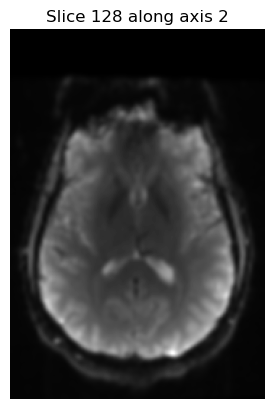

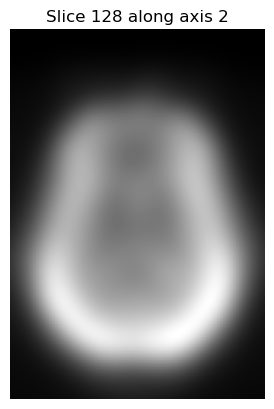

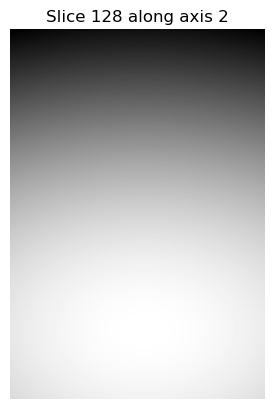

In [23]:
def display_nifti_image(image_path, slice_index=None, display_axis=2):
    """
    Display a slice from a NIfTI image.

    Parameters:
    - image_path (str): Path to the NIfTI file.
    - slice_index (int, optional): Index of the slice to display. If None, the middle slice is shown.
    - display_axis (int): Axis along which to slice the image (0, 1, or 2).
    """
    # Load the NIfTI image
    img = nb.load(image_path)
    data = img.get_fdata()

    # Set the default slice index to the middle slice if not provided
    if slice_index is None:
        slice_index = data.shape[display_axis] // 2

    # Extract the slice based on the selected axis
    if display_axis == 0:
        slice_data = data[slice_index, :, :]
    elif display_axis == 1:
        slice_data = data[:, slice_index, :]
    elif display_axis == 2:
        slice_data = data[:, :, slice_index]
    else:
        raise ValueError("Invalid display_axis value. Must be 0, 1, or 2.")

    # Plot the slice
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.title(f"Slice {slice_index} along axis {display_axis}")
    plt.axis('off')
    plt.show()

# Paths to the smoothed images
smoothed_1mm_path = '/home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/smoothing/_spatial_smooth_1mm2/sub-021_task-study_run-2_bold_volreg_flirt_maths.nii.gz'
smoothed_10mm_path = '/home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/smoothing/_spatial_smooth_10mm2/sub-021_task-study_run-2_bold_volreg_flirt_maths.nii.gz'
smoothed_100mm_path = '/home/nmatt015/Mattfeld_PSB6351/derivatives/preproc/sub-021/smoothing/_spatial_smooth_100mm2/sub-021_task-study_run-2_bold_volreg_flirt_maths.nii.gz'

# Display the middle slice for each smoothed image
display_nifti_image(smoothed_1mm_path, slice_index=None, display_axis=2)
display_nifti_image(smoothed_10mm_path, slice_index=None, display_axis=2)
display_nifti_image(smoothed_100mm_path, slice_index=None, display_axis=2)


### Now I will load and plot the motion files

In [ ]:
motion_dir = os.path.join(base_dir, f'derivatives/preproc/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))

for curr_mot_file in study_motion_files:
    # Read the motion parameters into a dataframe
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None, engine='python')
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']
    # Roll- rotation around the x axis
    # Pitch- rotation around the y axis
    # Yaw- rotation around the z axis
    # dS = displacement along superior inferior axis
    # dS- translation along the z axis
    # dL = displacement along the left right axis
    # dL- translation along the x axis
    # dP = displacement along the anterior posterior axis
    # dP- translation along the y axis

    # Prepare the figure and axes for plotting
    num_vols = range(1, len(motion_df) + 1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.3)  # Reduce space between plots

    # Change the colors so each parameter is unique
    colors = ['#FF0000', '#FF7F00', '#FFD700', '#00FF00', '#0000FF', '#8B00FF'] 

    # Plot each motion parameter
    for idx, (curr_col, color) in enumerate(zip(motion_df.columns, colors)):
        axs[idx].plot(num_vols, motion_df[curr_col], color=color, linewidth=1.5)
        axs[idx].set_ylabel(f'{curr_col}', fontsize=12)
        axs[idx].grid(True)

    # Set the x-axis label for the last subplot only, reads a bit easier 
    axs[-1].set_xlabel('Time (TRs)', fontsize=12)

    # Add a title for the entire figure
    fig.suptitle('Motion Parameters Across TRs', fontsize=16, y=0.95)

    # Display the plot
    plt.show()

####################################
# HW3 - compare the motion parameter plots from this script to 
# the carpet plot below.  What is the relationship between large rotations and/or translations and the carpet plot
# reference specific TRs and their relation to time.
####################################

In [ ]:
from nilearn.plotting import plot_carpet

from nilearn import masking

# Build an EPI-based mask because we have no anatomical data

####################################
# HW3 - compare different func files and their carpet plots
# which one are we looking at here? Which func file has the 
# most visually striking motion related changes in voxel intensity?
####################################

mask_img = masking.compute_epi_mask(func_files[0])

display = plot_carpet(
    func_files[0],
    mask_img,
    t_r=1.76,
    standardize="zscore_sample",
    title="global patterns over time",
)

display.show()